## In this notebook, we will generate stock prices using geometric brownian motion and using black scholes, we will price certian options and then proceed with delta hedging and analyse the results

In [73]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black Scholes Merten Model

## d1 and d2 calculation

In [74]:
def d1(S,K,r,T,sigma):
    val=(np.log(S/K) + (r+ 0.5 * sigma **2)*T)/ (sigma* np.sqrt(T))
    return val
def d2(S,K,r,T,sigma):
    val=(np.log(S/K) + (r- 0.5*sigma **2)*T)/(sigma * np.sqrt(T))
    return val

## Call and Put Prices

In [75]:
def call_price(S,K,r,T,sigma):
    d1_val=d1(S,K,r,T,sigma)
    d2_val=d2(S,K,r,T,sigma)
    price= S* norm.cdf(d1_val)-K* np.exp(-r * T) *norm.cdf(d2_val)
    return price
def put_price(S,K,r,T,sigma):
    d1_val=d1(S,K,r,T,sigma)
    d2_val=d2(S,K,r,T,sigma)
    price= K* np.exp(-r*T) * norm.cdf(-d2_val) - S* norm.cdf(-d1_val)
    return price

## The Greeks
-> Delta is the rate of change of an option's price with respect to the change in the price of the underlying asset. Δ= ∂V/∂S

-> Gamma is the rate of change of Delta with respect to the change in the underlying asset's price. Γ=∂S2/∂V2 = ∂Δ/∂S

-> Vega is the rate of change of an option's price with respect to a 1% change in implied volatility of the underlying asset. Vega= ∂V/∂σ

-> Theta measures the time decay of an option — how much the option's value decreases as one day passes, assuming all else remains constant.Θ= ∂V/∂t

In [76]:
def delta(S,K,r,T,sigma,option_type='call'):
    d1_val=d1(S,K,r,T,sigma)
    if option_type=='call':
        delta_val= norm.cdf(d1_val)
    else:
        delta_val= -norm.cdf(-d1_val)
    return delta_val

In [77]:
def gamma(S,K,r,T,sigma):
    d1_val=d1(S,K,r,T,sigma)
    gamma_val=norm.pdf(d1_val) / (S* sigma * np.sqrt(T))
    return gamma_val

In [78]:
def vega(S,K,r,T,sigma):
    d1_val=d1(S,K,r,T,sigma)
    vega_val=S*norm.pdf(d1_val) * np.sqrt(T)
    return vega_val

In [79]:
def theta(S,K,r,T,sigma,option_type='call'):
    d1_val=d1(S,K,r,T,sigma)
    d2_val=d2(S,K,r,T,sigma)
    term1=-(S*norm.pdf(d1_val)*sigma) / (2*np.sqrt(T))
    if option_type=='call':
        term2= -r*K * np.exp(-r*T)*norm.cdf(d2_val)
        return term1+term2
    else:
        term2= r*K * np.exp(-r*T)*norm.cdf(d2_val)
        return term1+term2

# Geometric Brownian Motion
-> To mimic real price data

In [80]:
def simulate_gbm(s, mu, sigma, T, steps):
    dt=T/steps
    prices=[s]
    for pt in range(steps):
        z=np.random.normal()
        s_t=prices[-1]*np.exp((mu-0.5*sigma**2)*dt+sigma*z*np.sqrt(T))
        prices.append(s_t)
    return prices

In [81]:
def update_time_to_maturity(initial_T, current_step, total_steps):
    dt=initial_T/total_steps
    return max(initial_T-current_step*dt,0.00001)

In [83]:
def simulate_portfolio_over_price_path(price_path, K, r, initial_T, sigma,option_type):
    steps=len(price_path)
    portfolio_values=[]
    for t in range(steps):
        s_t=price_path[t]
        T_t=update_time_to_maturity(initial_T,t,steps)
        if option_type=='call':
            price=call_price(s_t,K,r,T_t,sigma)
        else:
            price=put_price(s_t,K,r,T_t,sigma)
        portfolio_values.append(price)
    return portfolio_values

# Hedging Mechanism

## Staying Delta Neutral

In [129]:
def delta_neutral_hedge(price_path, T, K, r, sigma, option_type='call', quantity=100):
    hedge_positions = []
    cash_flows = []
    option_values = []
    portfolio_values = []
    deltas = []
    gammas = []
    vegas = []
    thetas = []
    total_steps = len(price_path)
    hedge_position = 0
    cash = 0
    for t in range(total_steps):
        S = price_path[t]
        T_left = update_time_to_maturity(T, t, total_steps)
        curr_delta = delta(S, K, r, T_left, sigma, option_type)
        curr_gamma = gamma(S, K, r, T_left, sigma)
        curr_vega = vega(S, K, r, T_left, sigma)
        curr_theta = theta(S, K, r, T_left, sigma, option_type)
        if option_type=='call':
            option_val = call_price(S, K, r, T_left, sigma) * quantity
        else:
            option_val = put_price(S, K, r, T_left, sigma) * quantity
        deltas.append(curr_delta)
        gammas.append(curr_gamma)
        vegas.append(curr_vega)
        thetas.append(curr_theta)
        target_stock_qty = -curr_delta * quantity
        if t == 0:
            hedge_change = target_stock_qty
            cash = cash - option_val - hedge_change * S
        else:
            hedge_change = target_stock_qty - hedge_position
            cash = cash -hedge_change * S 

        hedge_position = target_stock_qty
        hedge_value = hedge_position * S
        portfolio_val = option_val + hedge_value + cash

        # Log values
        hedge_positions.append(hedge_position)
        cash_flows.append(cash)
        option_values.append(option_val)
        portfolio_values.append(portfolio_val)

    # Return results as DataFrame
    result = pd.DataFrame({
        'Day': list(range(total_steps)),
        'Stock_Price': price_path,
        'Delta': deltas,
        'Gamma': gammas,
        'Vega': vegas,
        'Theta': thetas,
        'Hedge_Position': hedge_positions,
        'Cash': cash_flows,
        'Option_Value': option_values,
        'Portfolio_Value': portfolio_values
    })

    return result


# Performance

## Trial Testing on GBM generated Data

Text(0, 0.5, 'Prices')

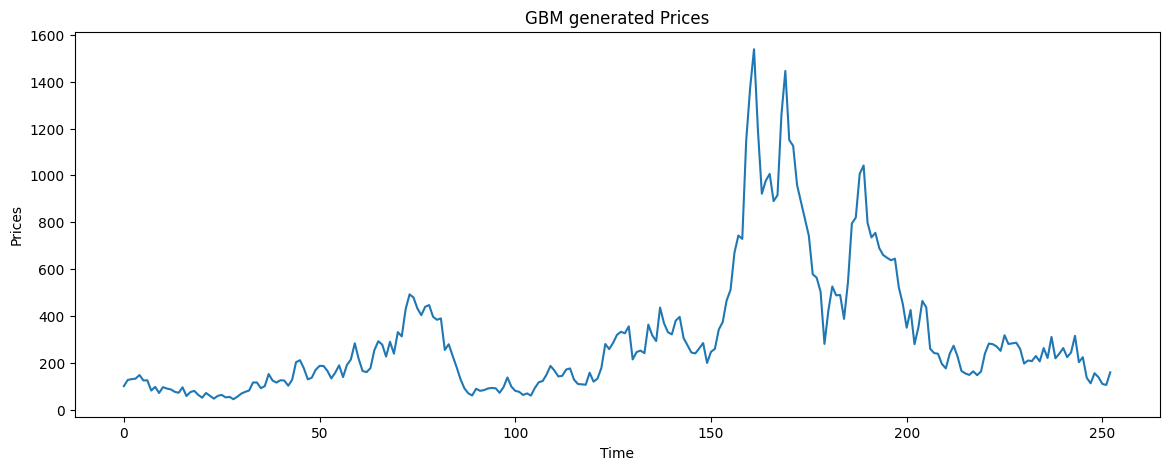

In [93]:
spot_prices = simulate_gbm(100, 0.05, 0.2, 1, 252)
portfolio_values_call = simulate_portfolio_over_price_path(spot_prices,100, 0.05, 1, 0.2,'call')
portfolio_values_put = simulate_portfolio_over_price_path(spot_prices,100, 0.05, 1, 0.2,'put')
plt.figure(figsize=(14, 5))
plt.plot(spot_prices)
plt.title("GBM generated Prices")
plt.xlabel("Time")
plt.ylabel("Prices")

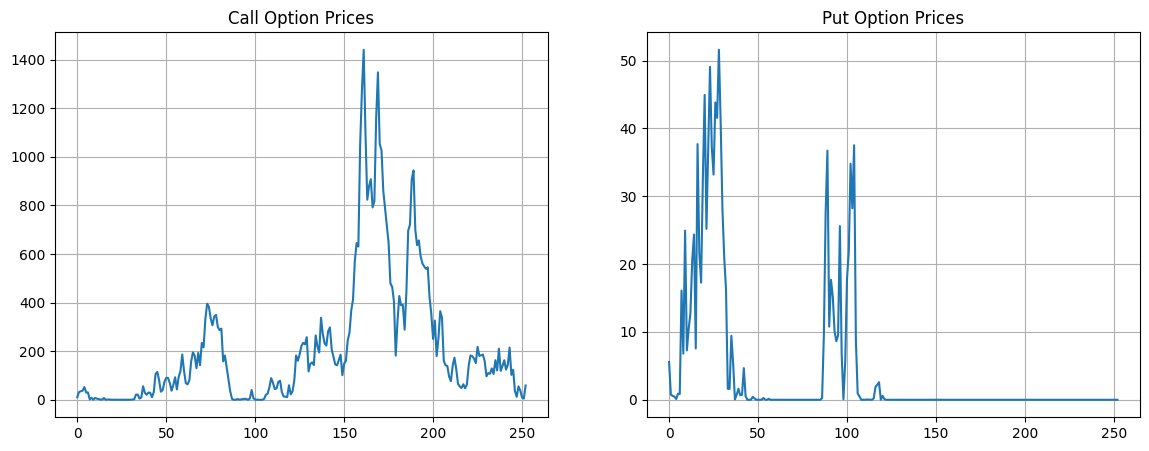

In [94]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(portfolio_values_call)
plt.title(f"Call Option Prices")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(portfolio_values_put)
plt.title(f"Put Option Prices")
plt.grid()
plt.show()

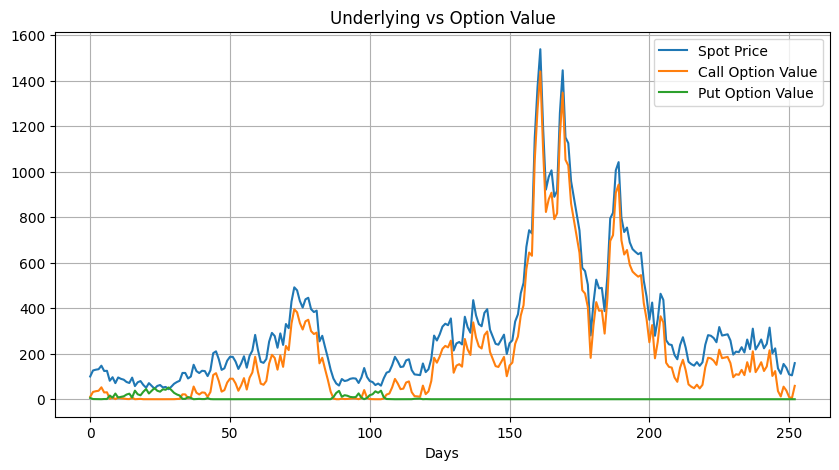

In [95]:
plt.figure(figsize=(10,5))
plt.plot(spot_prices, label='Spot Price')
plt.plot(portfolio_values_call, label='Call Option Value')
plt.plot(portfolio_values_put, label='Put Option Value')
plt.legend()
plt.title("Underlying vs Option Value")
plt.xlabel("Days")
plt.grid()
plt.show()

In [143]:
data=delta_neutral_hedge(spot_prices, 1, 100, 0.05, 0.2, option_type='call')
data.head()

,Day,Stock_Price,Delta,Gamma,Vega,Theta,Hedge_Position,Cash,Option_Value,Portfolio_Value
0,0,100.000000,0.636831,0.018762,37.524035,-6.414028,-63.683065,5323.248155,1045.058357,0.000000
1,1,126.384516,0.936048,0.004963,15.792347,-5.900427,-93.604835,9104.896506,3200.350574,475.045357
2,2,129.840571,0.951492,0.003892,13.019459,-5.727264,-95.149157,9305.412202,3524.331919,475.523240
3,3,131.939824,0.959253,0.003335,11.473131,-5.627935,-95.925347,9407.822641,3722.665482,474.114635
4,4,147.418657,0.989368,0.000961,4.111648,-5.093659,-98.936841,9851.772982,5233.358397,499.995170


In [144]:
def plot(data, column):
    plt.figure(figsize=(14,5))
    plt.plot(data[column])
    plt.title(column)
    plt.xlabel("Days")
    plt.grid()
    plt.show()

In [145]:
data['Daily_PnL'] = data['Portfolio_Value'].diff().fillna(0)
data['Cumulative_PnL'] =data['Daily_PnL'].cumsum()

In [147]:
ls=['Stock_Price', 'Delta', 'Gamma', 'Vega', 'Theta',
       'Hedge_Position', 'Cash', 'Option_Value', 'Portfolio_Value',
       'Daily_PnL', 'Cumulative_PnL']

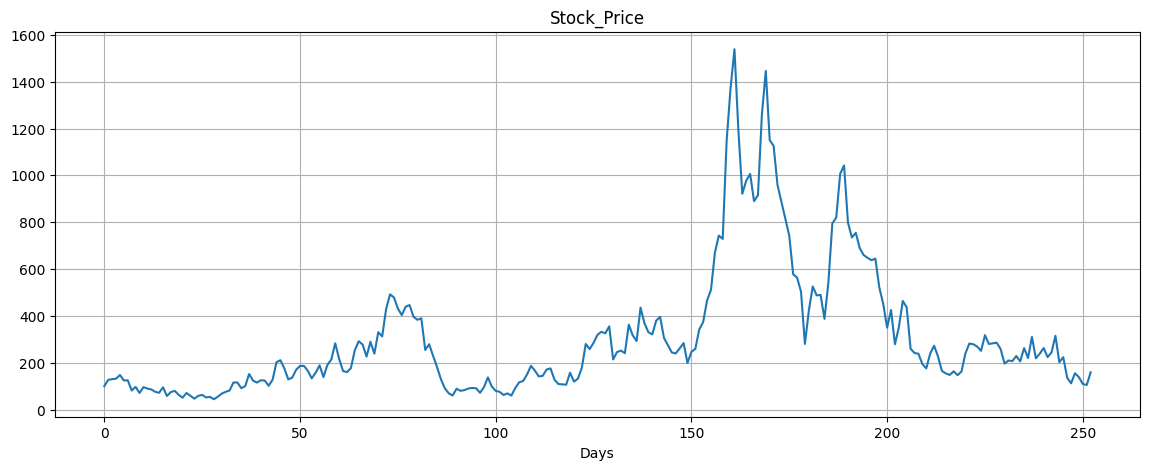

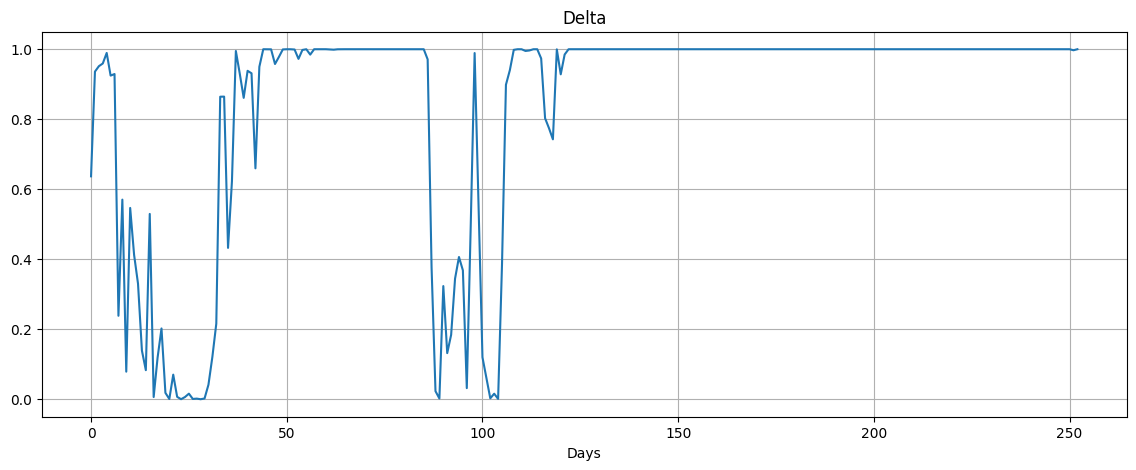

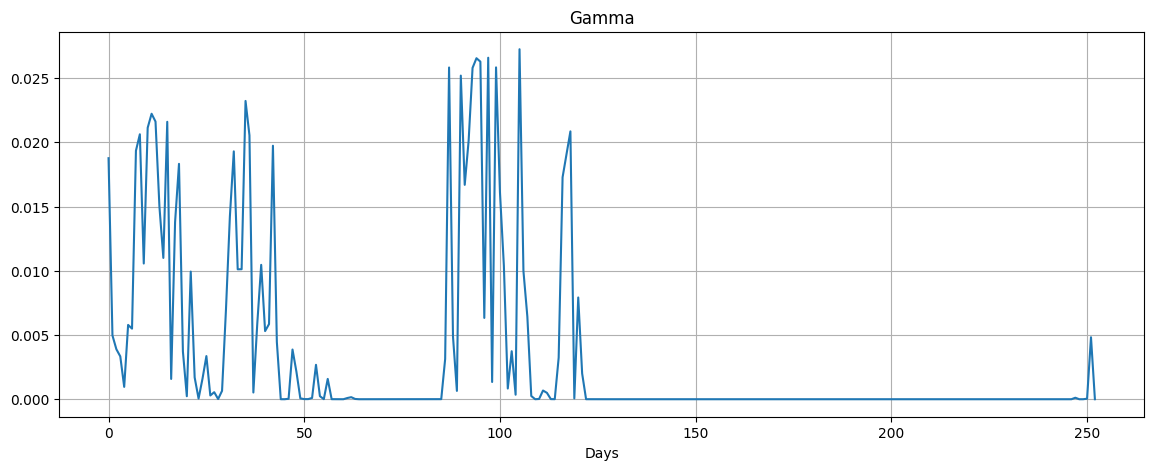

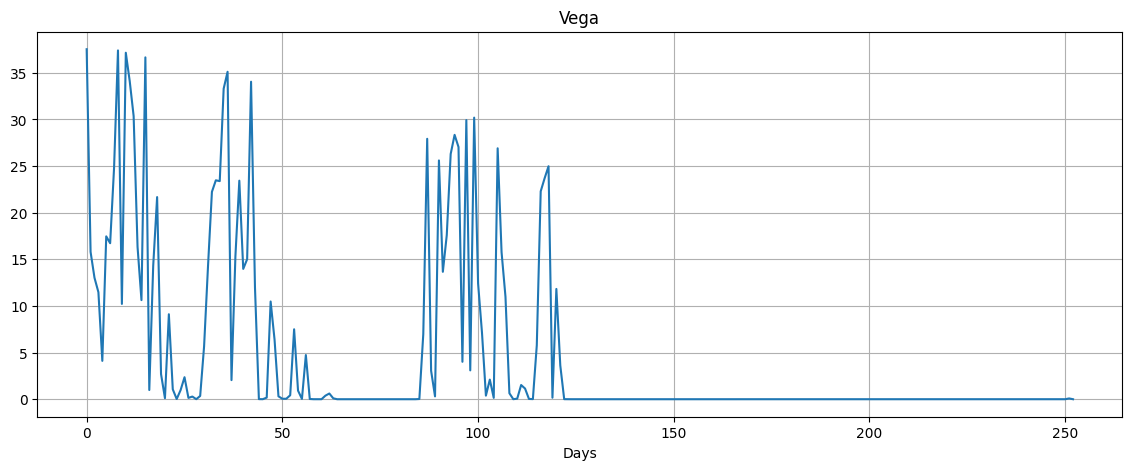

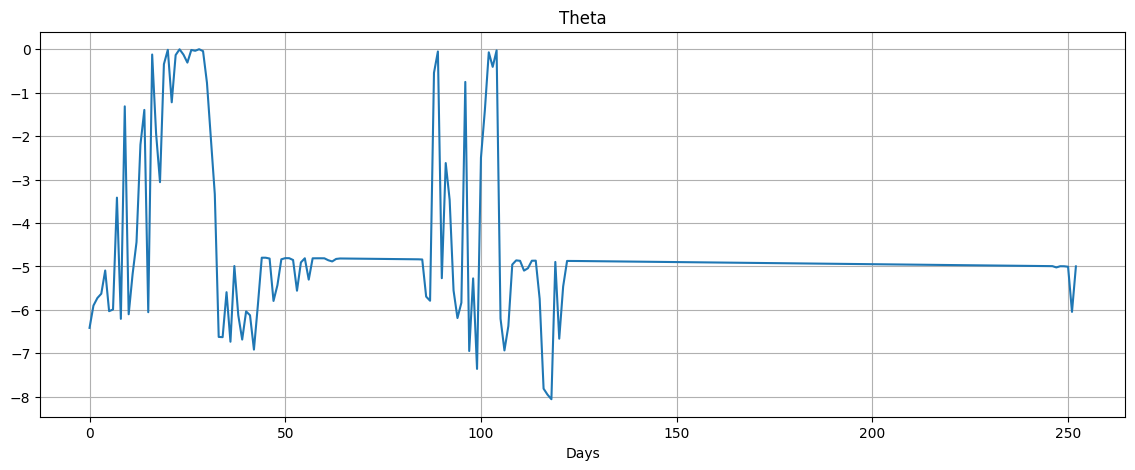

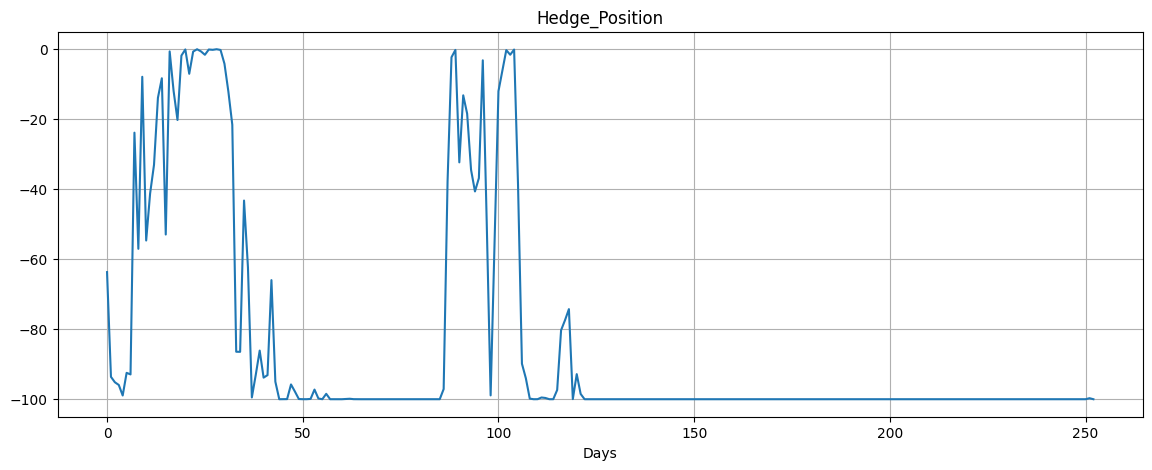

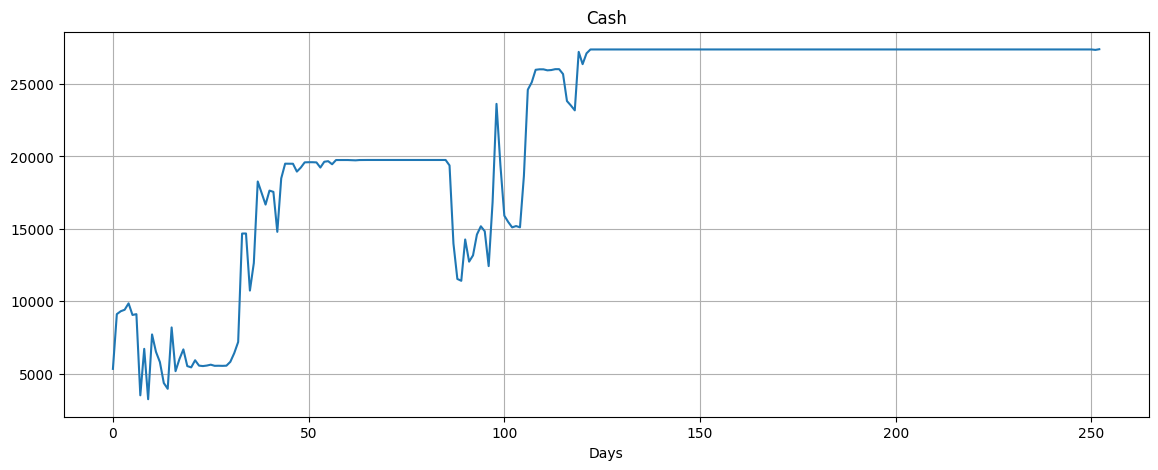

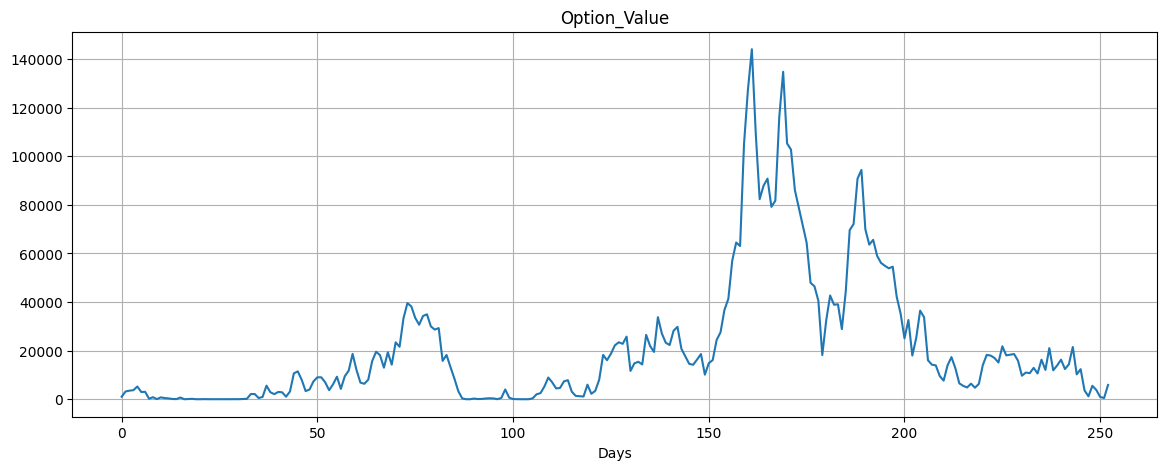

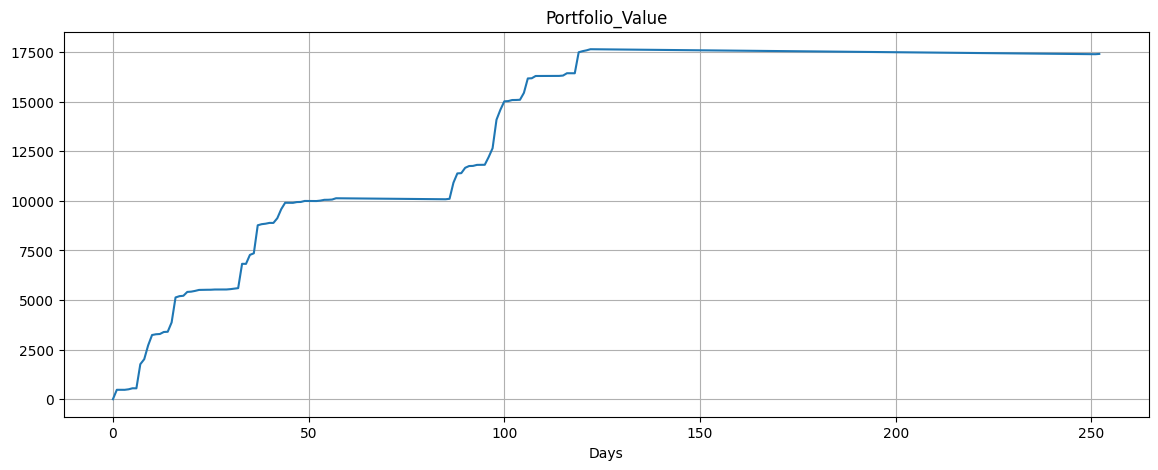

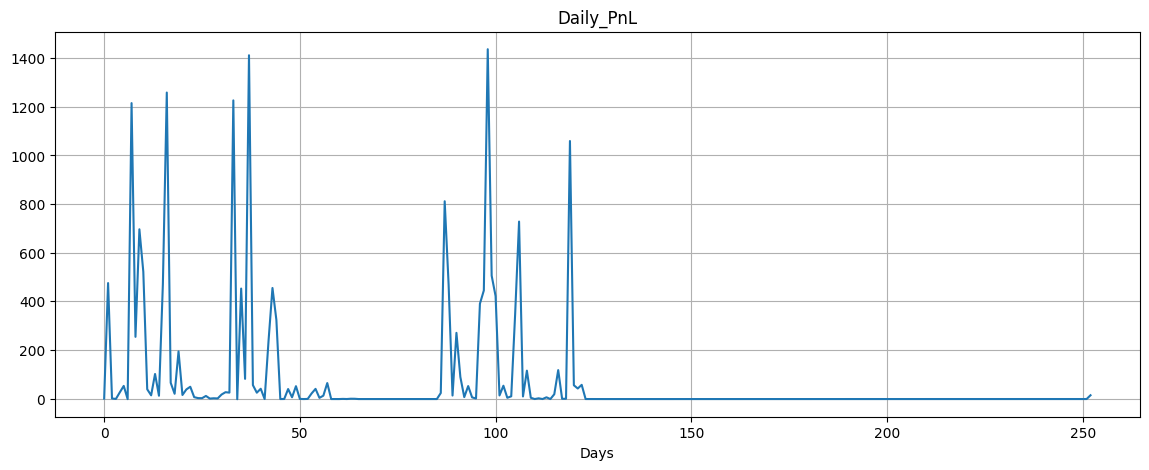

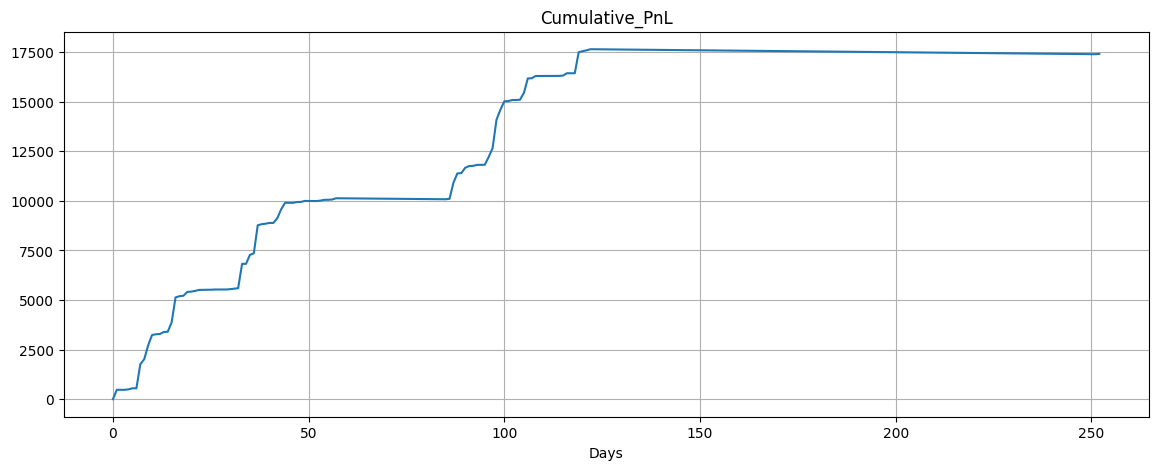

In [149]:
for i in ls:
    plot(data,i)